# Bootstrap example

1. Bootstrap the entire dataset
2. Parse ranking by accordance
3. Parse ranking by seasonality

In [2]:
import pandas as pd
import sys
import random
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np
from NcReader import *
from Experiment import *
from Stats import *

In [3]:
e = Experiment('/home/hma000/accomatic-web/tests/test_data/toml/SEP_KDI.toml')

df = e.mod().join(e.obs()).dropna()
df = df.groupby(['time']).mean()
df['ens'] = df[['era5','merr','jra5']].mean(axis=1)
models = ['ens','era5','merr','jra5']

/home/hma000/.conda/envs/acco/lib/python3.9/site-packages/pandas/core/indexes/base.py:327: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return libjoin.left_join_indexer_unique(sv, ov)


# Plotting timeseries visualization of data

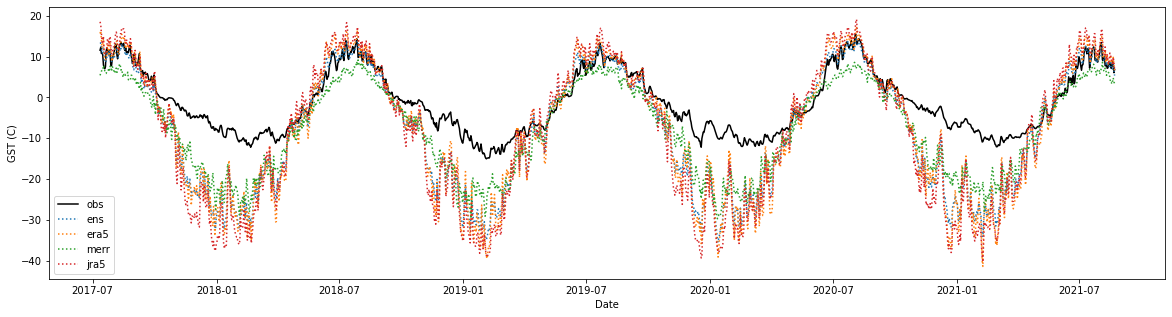

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.plot(df.index, df['obs'], 'k', label='obs')
for mod in models:
    plt.plot(df.index, df[mod], ':', label=mod)

# Set title and labels for axes
ax.set(xlabel="Date", ylabel="GST (C)")
ax.legend()
plt.show()

# Setting up bootstrap experiment

In [13]:

def boot(df, boot_size=1000, consecutive_days_slice=5):
    b_rmse, b_bias, b_r2 = [], [], []
    nrows = range(df.shape[0])

    for i in range(boot_size):
        # Select 5 consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = df.iloc[ix:ix+consecutive_days_slice, :]
        b_rmse.append(mean_squared_error(a['obs'], a['era5'], squared=False))
        b_bias.append((a['era5'] - a['obs']).sum()/consecutive_days_slice)
        b_r2.append(r2_score(a['obs'], a['era5']))
    
    return [np.array(b_rmse), np.array(b_bias), np.array(b_r2)]

b_res = boot(df) #(3, 1000)
for i in b_res:
    i = sorted(i)
    i = i[50:950]
    
print(len(b_res[0]))




NameError: name 'sort' is not defined

Text(0.5, 1.0, 'R2')

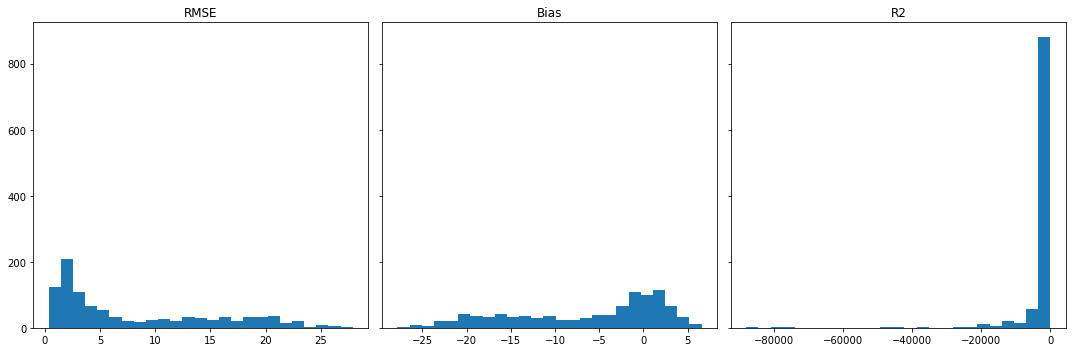

In [5]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))
# We can set the number of bins with the *bins* keyword argument.
n_bins = 25
axs[0].hist(b_res[0], bins=n_bins)
axs[0].set_title('RMSE')
axs[1].hist(b_res[1], bins=n_bins)
axs[1].set_title('Bias')
axs[2].hist(b_res[2], bins=n_bins)
axs[2].set_title('R2')


# Plotting histogram of bootstrap results

Text(0.5, 1.0, 'Bias')

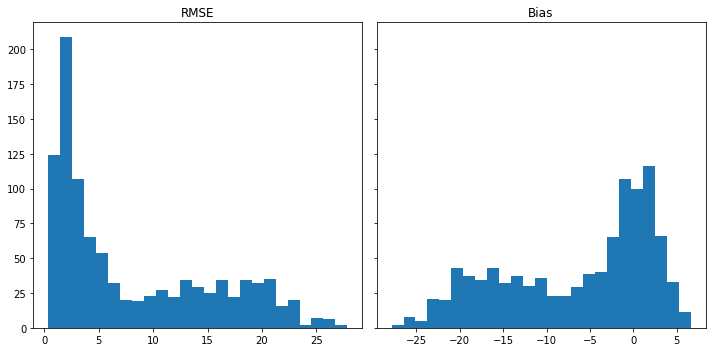

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,5))

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(b_res[0], bins=n_bins)
axs[0].set_title('RMSE')
axs[1].hist(b_res[1], bins=n_bins)
axs[1].set_title('Bias')

# Box and whisker plot of performance

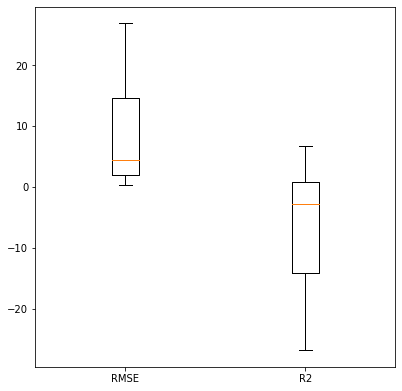

In [57]:
data = [b_res[0], b_res[1]]
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, notch=True)
ax.set_xticklabels(['RMSE', 'R2'])
plt.show()

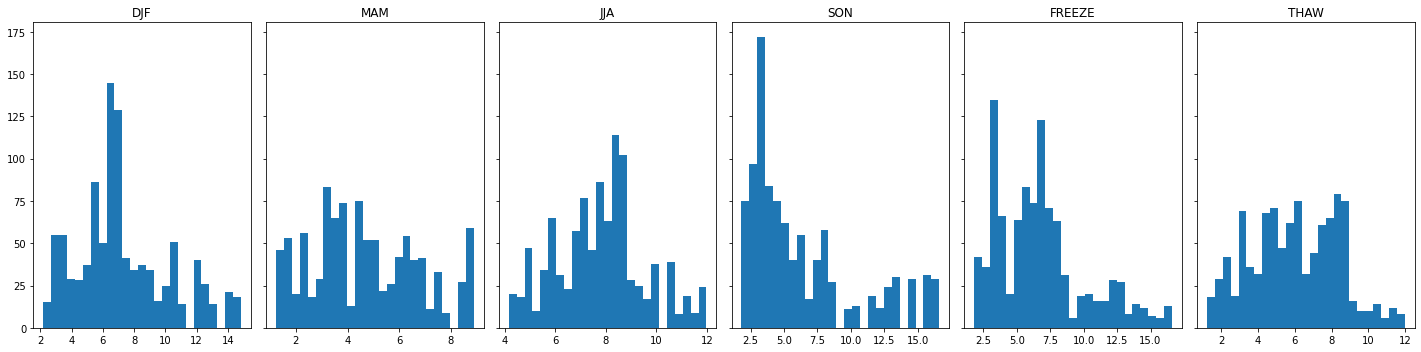

In [9]:
time_code_months = {
    "DJF": [1, 2, 12],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
    "FREEZE": [10, 11, 12, 1, 2, 3],
    "THAW": [4, 5, 6, 7, 8, 9],
}
data = []
fig, axs = plt.subplots(1, 6, sharey=True, tight_layout=True, figsize=(20, 5))
for szn, i in zip(time_code_months.keys(), range(0,6)):
    df_tmp = df[df.index.month.isin(time_code_months[szn])]
    df_tmp = df_tmp.reset_index(drop=True)

    t = 5 # Number of consecutive days to take 
    boot_size = 1000
    b_rmse, b_bias = [], []

    nrows = range(df_tmp.shape[0])

    for b in range(boot_size):
        # Select 5 consecutive days 
        ix = random.randint(nrows.start, nrows.stop-5)
        a = df_tmp.iloc[ix:ix+5, :]
        b_rmse.append(mean_squared_error(a['obs'], a['mod'], squared=False))
        # b_bias.append(np.mean(a['mod'] - a['obs']))

    b_rmse = np.array(b_rmse)
    data.append(b_rmse)
    axs[i].hist(b_rmse, bins=25)
    axs[i].set_title(szn)

plt.show()


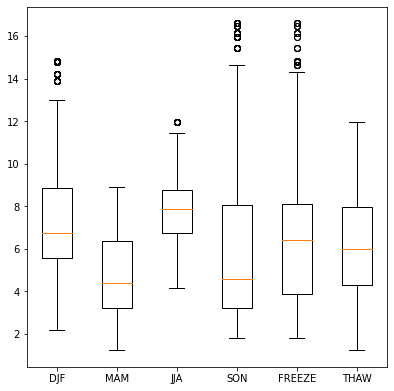

In [13]:
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.set_xticklabels(list(time_code_months.keys()))
plt.show()